# **Loading Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# **Generate random message**

In [4]:
# 隨機產生 (dataset_size)筆 message,  每筆message為11bit
def message_gen(dataset_size):
  m=np.zeros((dataset_size,11))
  for i in range(dataset_size):
    m[i] = np.array(np.random.randint(0, 2, 11))   
  return m

# **Encoding (15,11) Hamming code**

Define the generator matrix and parity check matrix and encode the message

In [ ]:
# 15,11 Hamming code 傳入11bit的message 並傳出對應的15bit codeword
# 找出 G 回傳 mG
def codeword_gen(m):
  H = np.array([[1,0,1,1,1,0,0,0,1,1,1,1,0,0,0],
                  [1,1,0,1,1,0,1,1,0,0,1,0,1,0,0],
                  [1,1,1,0,1,1,0,1,1,0,0,0,0,1,0],
                  [1,1,1,1,0,1,1,0,0,1,0,0,0,0,1]])
  P_T = H[:, :11]
  P=P_T.T
  I = np.eye(11)
  G = np.concatenate((I,P), axis=1)
  codeword=np.dot(m,G)%2
  return codeword

# **Modulation (BPSK)**

In [ ]:
def modulation(c,SNR):
  signal_power = 10**(SNR/10)
  x = 2*c - 1
  x = np.sqrt(signal_power) * x
  return x

# **AWGN channel**

In [ ]:
def AWGN_Channel(x, SNR):   
    # Calculate the noise power
    Es = np.mean(np.abs(x)**2)  # Signal power
    N0 = Es / (10**(SNR/10))    # Noise power
    # Generate Gaussian noise with the calculated noise power 
    n=len(x)
    noise=np.zeros((n,15))
    for i in range (n):
      noise[i]=np.random.normal(0, np.sqrt(N0/2), 15)
    y = x + noise
    return y

# **Splitting data into training and testing**

In [ ]:
def splitting_data(y,m,rate,file_size):
  train_size = round(file_size*rate)
  test_size = file_size - train_size
  train_y = y[0:train_size,:]
  train_m = m[0:train_size]
  test_y = y[train_size:file_size,:]
  test_m = m[train_size:file_size]
  return train_y, train_m, test_y, test_m, train_size, test_size

# Compiling the model

In [ ]:
def model_compile(SNR):
    # Define the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(15,)))
    model.add(tf.keras.layers.Dense(2048, activation='softmax'))
    LR = 0.001
    if(SNR==6):
      LR=0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main Function

SNR= 0
Epoch 1/25
547/547 [==============================] - 13s 9ms/step - loss: 3.1891 - accuracy: 0.4859 - val_loss: 1.1520 - val_accuracy: 0.7177
Epoch 2/25
547/547 [==============================] - 5s 9ms/step - loss: 0.8259 - accuracy: 0.7834 - val_loss: 0.9851 - val_accuracy: 0.7242
Epoch 3/25
547/547 [==============================] - 4s 7ms/step - loss: 0.6734 - accuracy: 0.8069 - val_loss: 1.0012 - val_accuracy: 0.7211
Epoch 4/25
547/547 [==============================] - 3s 6ms/step - loss: 0.5996 - accuracy: 0.8209 - val_loss: 1.0203 - val_accuracy: 0.7180
Epoch 5/25
547/547 [==============================] - 4s 7ms/step - loss: 0.5438 - accuracy: 0.8368 - val_loss: 1.0502 - val_accuracy: 0.7143
Epoch 6/25
547/547 [==============================] - 3s 5ms/step - loss: 0.5014 - accuracy: 0.8457 - val_loss: 1.0738 - val_accuracy: 0.7127
Epoch 7/25
547/547 [==============================] - 3s 6ms/step - loss: 0.4634 - accuracy: 0.8564 - val_loss: 1.1118 - val_accuracy: 0.709

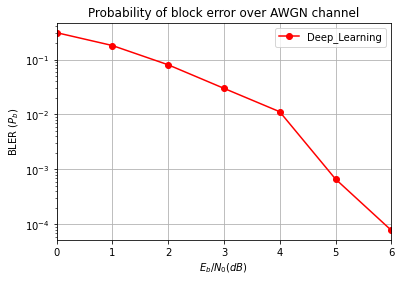

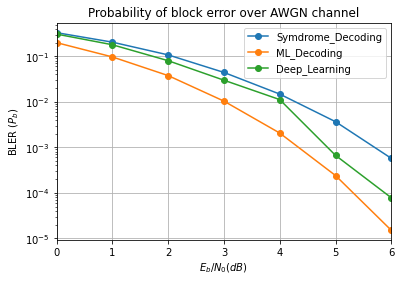

CPU times: user 9min 22s, sys: 1min 6s, total: 10min 28s
Wall time: 13min 8s


In [ ]:
%%time
SNR_start = 0
SNR_end = 6
step_size = 1
SNR = np.arange(SNR_start,SNR_end+1,step_size)
length_SNR = len(SNR)
BLER = np.zeros(length_SNR)
rate = 0.7 # training data rate
datasetsize4SNR = np.array([1e5, 1e5, 1e5, 1e5, 1e5, 1e5, 3e5, 8e6, 8e6],dtype=int) 
for i in range(length_SNR):
  print('SNR=',i)
  #------------------------------------#
  # transmitter part
  #------------------------------------#
  # generate message
  m=message_gen(datasetsize4SNR[i])   
  # generate codeword
  codeword=codeword_gen(m)
  # BPSK modulation
  c=modulation(codeword,SNR[i])
  # go through AWGN channel
  mes=AWGN_Channel(c,SNR[i])

  #------------------------------------#
  # receiver part
  #------------------------------------#
  # decoding by deep learning
  # split data
  m_modified = np.zeros(datasetsize4SNR[i])
  for j in range(datasetsize4SNR[i]):
    m_modified[j] += m[j,0]*1024+m[j,1]*512+m[j,2]*256+m[j,3]*128+m[j,4]*64+m[j,5]*32+m[j,6]*16+m[j,7]*8+m[j,8]*4+m[j,9]*2+m[j,10]*1

  # splitting_data
  [train_y,train_m,test_y,test_m,train_size,test_size] = splitting_data(mes, m_modified,rate,datasetsize4SNR[i])

  unique_category_count = 2048
  train_m_OneHot=tf.one_hot(train_m, unique_category_count)
  test_m_OneHot=tf.one_hot(test_m, unique_category_count)

  # define model
  model =model_compile(SNR[i])
  # training and fitting model
  if SNR[i]>=5:
      num_epochs = 6
  elif SNR[i]>=2:
      num_epochs = 40
  else:
      num_epochs = 25
  history = model.fit(train_y, train_m_OneHot, epochs=num_epochs, batch_size=128, validation_data=(test_y, test_m_OneHot))
  # predict by the model
  pred_m = model.predict(test_y)
  pred_m = np.argmax(pred_m, axis=1)
  # calculate error(BLER)
  test_error = np.sum(pred_m != test_m) / test_size 
  BLER[i] = test_error

  # BLER[i] = err/test_size
  print("BLER: ",BLER[i])
  print(i,"/",len(BLER)-1)
#Reuse the results of last time
BLER_SymdromeDecoding = [0.33146, 0.20494, 0.10756, 0.04429, 0.0148, 0.00366, 0.0005725]
BLER_ML = [1.9999e-01, 9.7070e-02, 3.7740e-02, 1.0370e-02, 2.0600e-03, 2.4000e-04, 1.5000e-05]
#Plot BLER
EbN0dBs = np.arange(start=SNR_start,stop=SNR_end+1,step=step_size)
fig1 = plt.figure(1)
plt.semilogy(EbN0dBs,BLER,color='r',marker='o',linestyle='-',label='Deep_Learning')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
print("Block Error Rate:", BLER)
fig2 = plt.figure(2)
plt.semilogy(EbN0dBs,BLER_SymdromeDecoding[SNR_start:SNR_end+1],marker='o',linestyle='-',label='Symdrome_Decoding')
# plt.semilogy(EbN0dBs,BLER_SVM[SNR_start:SNR_end+1],marker='o',linestyle='-',label='SVM')
plt.semilogy(EbN0dBs,BLER_ML[SNR_start:SNR_end+1],marker='o',linestyle='-',label='ML_Decoding')
plt.semilogy(EbN0dBs,BLER,marker='o',linestyle='-',label='Deep_Learning')
plt.xlabel('$E_b/N_0(dB)$');plt.ylabel('BLER ($P_b$)')
plt.title('Probability of block error over AWGN channel')
plt.xlim(SNR_start,SNR_end);plt.grid(True);
plt.legend()
plt.show()